## Convocatoria 1 - Proyecto 1

#### 0) Cargar una de las imágenes histológicas

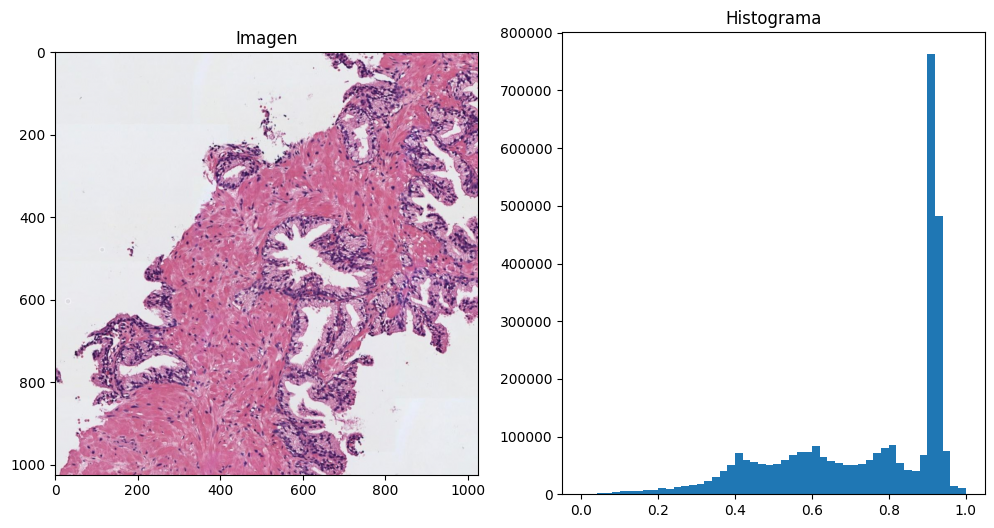

In [54]:
# Utilizar la librería skimage.io para leer la imagen 'histo_x.jpg' en formato RGB.
# Normalizar la imagen para que los píxeles se encuentren en el rango [0, 1]
# Visualizar la imagen

import numpy as np
import matplotlib.pyplot as plt
import skimage.io as io
import cv2

img = io.imread('histo_1.jpg')/255

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

ax1.imshow(img), ax1.set_title('Imagen')

ax2.hist(img.flatten(), bins=50, range=[0, 1]), ax2.set_title('Histograma')

plt.show()

#### 1) Realizar una transformación de color para convertir la imagen al espacio de color CMYK

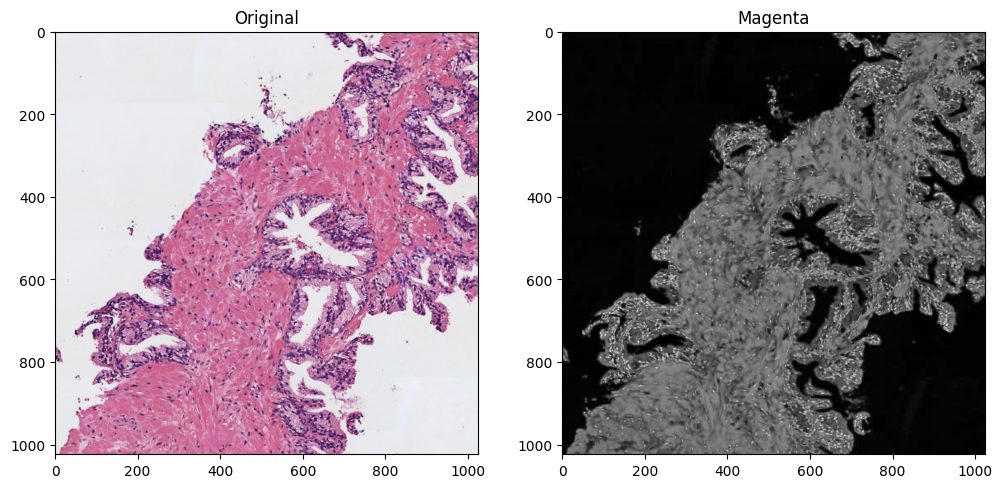

In [2]:
# Extraer la componente magenta de la imagen (que corresponde a la región tisular)
# Visualizar la imagen del canal magenta

with np.errstate(invalid='ignore', divide='ignore'):
    K = 1 - np.max(img, axis=2)
    C = (1-img[:,:,0]-K)/(1-K)
    M = (1-img[:,:,1]-K)/(1-K)
    Y = (1-img[:,:,2]-K)/(1-K)

CMYK = (np.dstack((C,M,Y,K))*255).astype('uint8')
C,M,Y,K = cv2.split(CMYK)

# Visualización
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

ax[0].imshow(img), ax[0].set_title('Original')
ax[1].imshow(M.astype('uint8'), cmap='gray'), ax[1].set_title('Magenta')

plt.show()

#### 2) Umbralizar la imagen para separar los píxeles del fondo de la región tisular

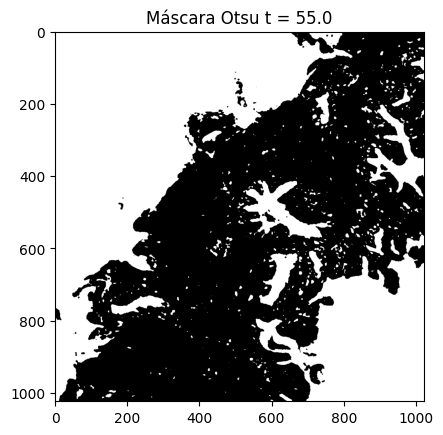

In [3]:
# Aplicar un filtro gaussiano de tamaño 5x5 y después utilizar el método de Otsu de manera que
# los píxeles correspondientes al lumen y al background de la imagen sean 1s y el resto de los píxeles tengan un valor de 0.
# Nota: Recordar que el método de Otsu requiere como input una imagen en el rango [0-255] en formato "uint8".
# Visualizar la máscara resultante

gaussian_img = cv2.GaussianBlur(M, (5,5), 0)
t, mask = cv2.threshold(gaussian_img, 0, 1, cv2.THRESH_OTSU)

mask = 1 - mask

plt.title('Máscara Otsu t = ' + str(t))
plt.imshow(mask, cmap='gray')
plt.show()

#### 3) Limpiar la imagen eliminando los artefactos de lumen (objetos blancos pequeños que no son lúmenes)

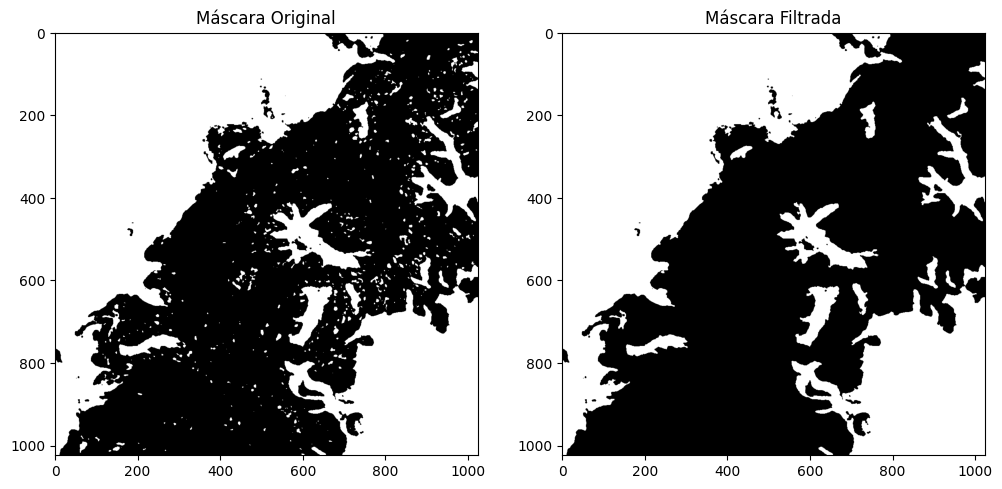

In [4]:
# Utilizar la librería skimage.morphology.remove_small_objects para eliminar aquellos objetos cuya área sea menor a 300 píxeles
# Más información en https://scikit-image.org/docs/dev/api/skimage.morphology.html#skimage.morphology.remove_small_objects
# Visualizaer la máscara resultante

from skimage import morphology

mask_filtered = morphology.remove_small_objects(mask.astype(bool), min_size=300)
mask_filtered = mask_filtered.astype('uint8')

fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].imshow(mask, cmap='gray'), ax[0].set_title('Máscara Original')
ax[1].imshow(mask_filtered, cmap='gray'), ax[1].set_title('Máscara Filtrada')

plt.show()

#### 4) Rellenar con 0s el fondo de la imagen para quedarnos únicamente con los lúmenes

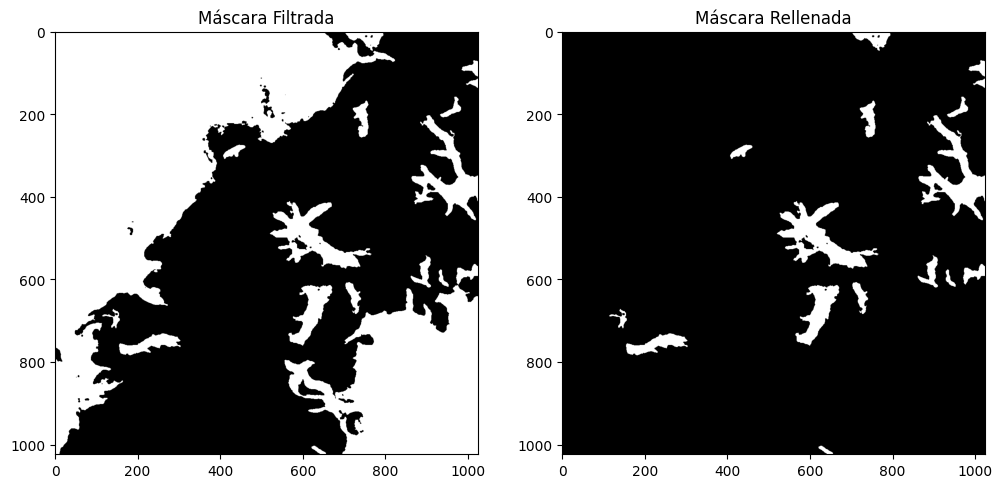

In [5]:
# Aplicar el algoritmo de expansión a partir de semillas (region growing) de manera que únicamente los lúmenes sean blancos
# y el resto de la imagen negra. Pista: utilizar dos semillas. Nota: Se pueden fijar las semillas de manera manual, pero
# se valorará positivamente a aquell@s que desarrollen una función para encontrarlas automáticamente.
# Visualizar la máscara resultante. 

mask_lumenes = mask_filtered.copy()

h, w = mask_lumenes.shape
ref = np.zeros((h+2, w+2), np.uint8)

seed_points = [(0, 0), (w-1, w-1)]

for seed_point in seed_points:
    cv2.floodFill(mask_lumenes, ref, seed_point, 0)

fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].imshow(mask_filtered, cmap='gray'), ax[0].set_title('Máscara Filtrada')
ax[1].imshow(mask_lumenes, cmap='gray'), ax[1].set_title('Máscara Rellenada')

plt.show()

#### 5) Rellenar los objetos de los lúmenes

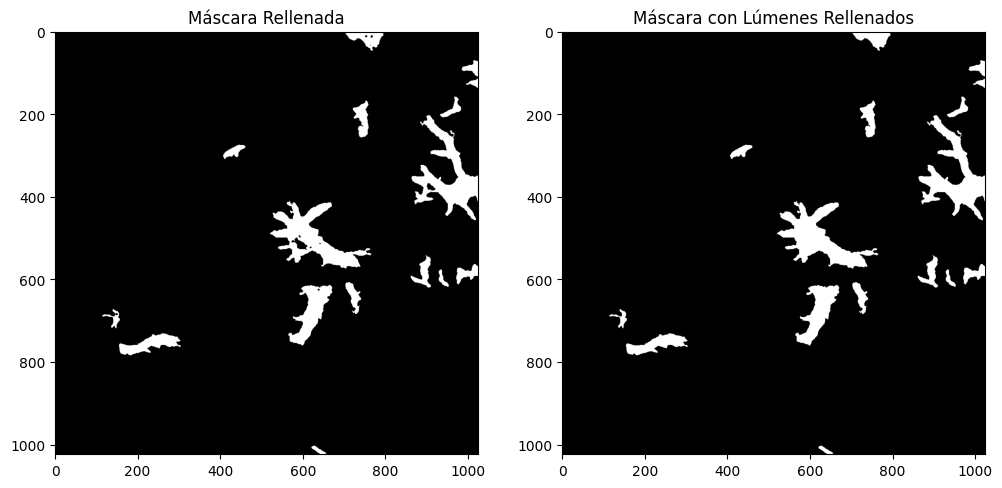

In [12]:
# Rellenar los lúmenes con la función binary_fill_holes de la librería scipy.ndimage.morphology
# Visualizar la máscara resultante

from scipy.ndimage import binary_fill_holes as bfh

mask_filled = bfh(mask_lumenes)
mask_filled = mask_filled.astype('uint8')

fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].imshow(mask_lumenes, cmap='gray'), ax[0].set_title('Máscara Rellenada')
ax[1].imshow(mask_filled, cmap='gray'), ax[1].set_title('Máscara con Lúmenes Rellenados')

plt.show()

#### 6) Detectar y dibujar los contornos de los lúmenes sobre la imagen original

Número de objetos:  16


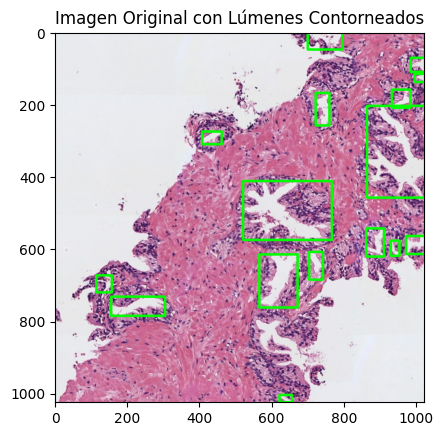

In [66]:
# Dibujar los contornos de los lúmenes en color verde sobre la imagen original RGB. Nota: Utilizar los flags necesarios
# para que los contornos en verde sean perfectamente visibles. 
# Visualizar la imagen superpuesta

from skimage.measure import label
from skimage.measure import regionprops

lab, num = label(mask_filled, return_num=True)

print('Número de objetos: ', num)

img_contours = img.copy()

for i in range(1, num+1):

    objeto = lab == i
    objeto = objeto.astype('uint8')

    prop = regionprops(objeto)
    bbox = prop[0].bbox
    start_point = (bbox[1], bbox[0])
    end_point = (bbox[3], bbox[2])
    cv2.rectangle(img_contours, start_point, end_point, (0, 1, 0), 5)

plt.title('Imagen Original con Lúmenes Contorneados')
plt.imshow(img_contours)
plt.show()

#### 7) Identificar y cropear el lumen más grande

Lumen de mayor área:  8
Área:  14110.0


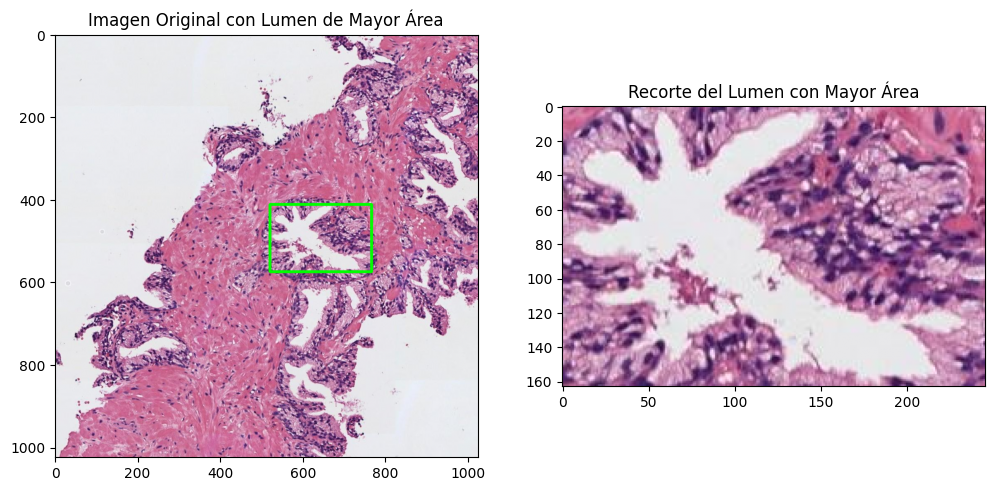

In [86]:
# Determinar cuál es el lumen de mayor área y hacer un crop del mismo sobre la imagen original RGB.
# Visualizar el lumen cropeado.

max_area = 0
max_area_index = 0

for i in range(1, num+1):

    objeto = lab == i
    objeto = objeto.astype('uint8')

    prop = regionprops(objeto)
    area = prop[0].area

    if area > max_area:
        max_area = area
        max_area_index = i

print('Lumen de mayor área: ', max_area_index)
print('Área: ', max_area)
img_max_lumen = img.copy()

objeto = lab == max_area_index
objeto = objeto.astype('uint8')
prop = regionprops(objeto)
bbox = prop[0].bbox
start_point = (bbox[1], bbox[0])
end_point = (bbox[3], bbox[2])
cv2.rectangle(img_max_lumen, start_point, end_point, (0, 1, 0), 5)

img_cropped = img[bbox[0]:bbox[2], bbox[1]:bbox[3]]

fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].imshow(img_max_lumen), ax[0].set_title('Imagen Original con Lumen de Mayor Área')
ax[1].imshow(img_cropped), ax[1].set_title('Recorte del Lumen con Mayor Área')

plt.show()

#### 8) Extraer 13 características geométricas que permitan caracterizar el lumen recortado 

In [98]:
# Calcular las siguientes características del crop del lumen de mayor área, redondeando su valor hasta el cuarto decimal.
# 1) Área
# 2) Área de la bounding box
# 3) Área convexa
# 4) Exentricidad
# 5) Diámetro equivalente
# 6) Extensión
# 7) Diámetro Feret
# 8) Longitud del eje mayor
# 9) Longitud del eje menor
# 10) Orientación
# 11) Perímetro
# 12) Solidez
# 13) Compacidad

from tabulate import tabulate
import math

# Extraemos las característicias geométricas
A,BB,CA,E,ED,EX,DF,MA,MiA,OR,P,S,CO = ['Área'], ['Área de la bounding box'], ['Área convexa'], ['Exentricidad'], ['Diámetro equivalente'], \
['Extensión'], ['Diámetro Feret'], ['Longitud del eje mayor'], ['Longitud del eje menor'], ['Orientación'], ['Perímetro'], ['Solidez'], ['Compacidad']

A.append(np.round(prop[0].area, 4))
BB.append(np.round(prop[0].bbox_area, 4))
CA.append(np.round(prop[0].convex_area, 4))
E.append(np.round(prop[0].eccentricity, 4))
ED.append(np.round(prop[0].equivalent_diameter, 4))
EX.append(np.round(prop[0].extent, 4))
DF.append(np.round(prop[0].feret_diameter_max, 4))
MA.append(np.round(prop[0].major_axis_length, 4))
MiA.append(np.round(prop[0].minor_axis_length, 4))
OR.append(np.round(prop[0].orientation, 4))
P.append(np.round(prop[0].perimeter, 4))
S.append(np.round(prop[0].solidity, 4))
CO.append(np.round(4*math.pi*prop[0].area/prop[0].perimeter**2, 4))


my_data = [tuple(A), tuple(BB), tuple(CA), tuple(E), tuple(ED), tuple(EX), tuple(DF),\
          tuple(MA), tuple(MiA), tuple(OR), tuple(P), tuple(S), tuple(CO)]

print(tabulate(my_data, headers=['Lumen de Mayor Área']))

                           Lumen de Mayor Área
-----------------------  ---------------------
Área                                14110
Área de la bounding box             40098
Área convexa                        29267
Exentricidad                            0.847
Diámetro equivalente                  134.035
Extensión                               0.3519
Diámetro Feret                        259.077
Longitud del eje mayor                238.527
Longitud del eje menor                126.796
Orientación                             1.0052
Perímetro                            1238.32
Solidez                                 0.4821
Compacidad                              0.1156
